In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as utils
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# set seed
torch.manual_seed(42)
np.random.seed(42)


In [14]:
from typing import Tuple, List, Callable
from torch.distributions import Distribution
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from sklearn import metrics
from tqdm import tqdm
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
from IPython.display import clear_output


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
# https://sebastiancallh.github.io/post/affine-normalizing-flows/
# uses Real NVP paper

# Define the Normalising Flow model template
class NormalisingFlow(nn.Module):

    def __init__(self, latent: Distribution, flows: List[nn.Module]):
        super(NormalisingFlow, self).__init__()
        self.latent = latent
        self.flows = nn.ModuleList(flows)

    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        return self.latent.log_prob(z)

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        return self.latent.sample((num_samples,))

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        '''Sample a new observation x by sampling z from
        the latent distribution and pass through g.'''
        return self.g(self.latent_sample(num_samples))

    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        '''Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inverse of g.'''
        #z, sum_log_abs_det = x, torch.zeros(x.size(0)).to(device) # change to x device
        
        z, sum_log_abs_det = x, torch.zeros(x.size(0), device = x.device)
        for flow in self.flows: # for each transformation in the flow
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''Maps latent variable z to observation x.
        Inverse of f.'''
        with torch.no_grad():
            x = z
            #x = z.to(self.flows[0].theta[0][0].weight.device)
            for flow in reversed(self.flows):
                x = flow.g(x)

        return x

    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        '''Maps latent variable z to observation x
        and stores intermediate results.'''
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))

        return xs

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        '''Computes log p(x) using the change of variable formula.'''
        z, log_abs_det = self.f(x)
        log_prob_x = self.latent_log_prob(z) + log_abs_det
        return log_prob_x

    def __len__(self) -> int:
        return len(self.flows)


class AffineCouplingLayer(nn.Module):

    def __init__(self, theta: nn.Module, split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]):
        super(AffineCouplingLayer, self).__init__()
        self.theta = theta
        self.split = split

    def f(self, x: torch.Tensor) -> torch.Tensor:
        '''f: x -> z. The inverse of g.'''
        x2, x1 = self.split(x) # flip the split #insert other permutation for 3D+ data
        ### permutation at one point
        t, s = self.theta(x1)
        # Tau coupling function: e^s + t
        z1, z2 = x1, x2 * torch.exp(s) + t
        log_det = s.sum(-1) # sum over the last dimension
        return torch.cat((z1, z2), dim=-1), log_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''g: z -> x. The inverse of f.'''
        z1, z2 = self.split(z)
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        return torch.cat((x2, x1), dim=-1)


class Conditioner(nn.Module):
    'The conditioner is the Neural Network that helps fit the model to the data by learning theta_i = (s_i,t_i)'

    def __init__(self, in_dim: int, out_dim: int, num_hidden: int, hidden_dim: int, num_params: int):
        super(Conditioner, self).__init__()
        self.input = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  
            nn.LeakyReLU(inplace=True)  
        )
        self.hidden = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),  
                nn.Dropout(0.3),
                nn.LeakyReLU(inplace=True)  
            )
            for _ in range(num_hidden)
        ])

        self.num_params = num_params
        self.out_dim = out_dim
        self.output = nn.Linear(hidden_dim, out_dim * num_params)
        # initialisere output lag conditioner alle vægte og bias til 0
        nn.init.zeros_(self.output.weight)
        nn.init.zeros_(self.output.bias) 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input(x)
        for h in self.hidden:
            x = h(x)

        batch_params = self.output(x).reshape(x.size(0), self.out_dim, -1)
        #batch_params[:,:,1] *= 0.001
        #batch_params[:,:,0] *= 0.001 
        params = batch_params.chunk(self.num_params, dim=-1)
        return [p.squeeze(-1) for p in params]

class CNN(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        super(CNN, self).__init__()
        # input: 3 x 32 x 32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) 
        # kernel size is 3x3 with padding 1, so the output size is the same as the input size 
        # 32-3+2*1/1 + 1 = 32
        # we want 16 kernels (aka filters)
        # after conv1: 16 x 32 x 32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # kernel size is 2x2 with stride 2, so the output size is half of the input size
        # after pool1: 16 x 16 x 16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # kernel size is 3x3 with padding 1, so the output size is the same as the input size 
        # but double the filters (32)
        # after conv2: 32 x 16 x 16
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # kernel size is 2x2 with stride 2, so the output size is half of the input size
        # after pool2: 32 x 8 x 8

        self.flat = nn.Flatten()
        # I want the feature space to be 2D?? eller 10 for num_classe
        self.fc1 = nn.Linear(32*8*8, latent_dim) 
        self.batchnorm1 = nn.BatchNorm1d(latent_dim) 


        ## Afprøve:
        # learning rate scheduler
        # rapport
        # Langt tid senere: korrekte usikkerheder senere
        # plot i datarummet - meshgrid - normaliseret alpha eller flows

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flat(x)
        x = self.fc1(x)
        x = self.batchnorm1(x)
        return x

In [17]:
class PosteriorNetwork(nn.Module):
    def __init__(self, latent_dim: int, flow_models: List[nn.Module], N: torch.tensor, num_classes: int, y: torch.Tensor):
        super(PosteriorNetwork, self).__init__()
        self.cnn = CNN(latent_dim)
        self.flow_models = nn.ModuleList(flow_models)
        self.N = N
        self.y = y
        self.num_classes = num_classes 
    
    def forward(self, x, N):
        batch_size = x.size(0)
        # N is number of inputs in each class total
        z = self.cnn(x) 
        # for each class, since outputdim = num_classes
        alpha = torch.zeros((batch_size, self.num_classes)).to(z.device.type)
        log_q = torch.zeros((batch_size, self.num_classes)).to(z.device.type)
        beta_i = torch.zeros((batch_size, self.num_classes)).to(z.device.type)

        # for each class, compute 
        for c in range(self.num_classes):
            log_prob = self.flow_models[c].log_prob(z) #P(z|c,phi)
            log_q[:,c] = log_prob
            beta_prior = 1 
            beta_i[:,c] = N[c] * torch.exp(log_prob)  #formula (4) from paper
            alpha[:,c] = beta_prior + beta_i[:,c] #or just beta_i[c]?

        # grad_loss
        #loss = self.loss_postnet(alpha, y, batch_size)

        ##alpha = F.normalize(alpha, p=1, dim=1) # to get p^bar_c which is the average of alphas
        #preds = self.predict(alphas) #categorical prediction using argmax on p_bar_c
        return alpha

    def loss_postnet(self, alpha, y, batch_size): #UCE loss 
        #alpha is the p vector with alphas for each class
        #y_hot is the ground-truth class labels
        alpha_0 = torch.sum(alpha, dim=1, keepdim=True) #batch x 1
        digamma_alpha_c = torch.digamma(alpha[range(batch_size),y]) # batch x 1

        digamma_alpha_0 = torch.digamma(alpha_0) # batch x 1, hver obs får sin egent logprobs
        uce_loss = digamma_alpha_c - digamma_alpha_0 #elementwise
        #uncertain_loss = torch.sum((digamma_alpha_c - digamma_alpha_sum) * alpha, dim=1)
        
        # entropy in Dirichlet distribution
        uce_loss = -torch.mean(uce_loss) #negative since we want to minimize the loss
        #approximates the true posterior distribution for the categorical distribution p
        return uce_loss

In [27]:
# Load CIFAR-10 data
data_path = './'
cifar10 =  datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

# Convert PIL images [0,1] to pytorch tensors [-1,1]
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalise pixel values by subtracting 0.5 and dividing by 0.5
    ])

batch_size = 64 # standard value
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# # Create a dataloader for batching and shuffling
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
# test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

from torch.utils.data.dataset import Subset
subset_percentage = 0.04

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

num_samples = int(len(train_dataset) * subset_percentage)
train_subset = Subset(train_dataset, range(num_samples))
test_subset = Subset(test_dataset, range(num_samples)) 

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Get ground-truth label counts N_c
# Dictionary with class names from indexes.
classes = {index: name for name, index in train_dataset.class_to_idx.items()}
print(classes)

# Initialise dictionary to store the counts for each class using class indexes
N = {index: 0 for index in range(len(classes))}
# Count the occurrences of each class
for _, target in train_dataset:
    N[target] += 1
N = torch.tensor([N[index] for index in range(len(classes))])
print(N)

y_train = torch.tensor([target for _, target in train_dataset])
print(y_train)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])
tensor([6, 9, 9,  ..., 9, 1, 1])


In [28]:
def image_show(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   #Unnormalise
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def init_weights(model):
    if isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        nn.init.zeros_(model.bias) 

In [23]:
# Get random training images and show them.
# images, labels = next(iter(train_loader))
# image_show(utils.make_grid(images))

In [29]:
num_classes = 10
latent_dim = 2 # the encoder outputs 2D latent space
data_dim = 2 # the encoder outputs 2D latent space
in_dim= data_dim // 2 # since we split the data
out_dim= data_dim // 2
num_params = 2 # s and t
num_hidden = 2 # number of hidden layers
hidden_dim = 32 # neurons in hidden layers
num_flows = 4 # number of coupling flow layers

#lr = 0.0031
lr = 0.01
weight_decay = 1e-6  # L2 regularization strength to prevent overfitting in Adam or AdamW 
num_epochs = 100 # flere epochs maybe 12000
batch_size = 64
validation_every_steps = 10
#validation_every_epochs = 5
early_stop_delta = 0.0001
early_stop_patience = 15

# initalise the flows and postnet model
flow_models = []
for class_label in range(num_classes):
    conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
    flows = [affine_coupling for _ in range(num_flows)]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device)) #maybe move out of loop?

    flow_model = NormalisingFlow(latent_distribution, flows).to(device)
    #flow_model = NormalisingFlow(latent_distribution, flows).apply(init_weights).to(device)
    flow_models.append(flow_model)

postnet_model = PosteriorNetwork(latent_dim, flow_models, N, num_classes, y_train).to(device) 
optimiser = optim.AdamW(postnet_model.parameters(), lr=lr, weight_decay=weight_decay)

In [30]:
############## TRAINING ######################
##############################################
def accuracy(y_train, preds):
    accuracy = accuracy_score(y_train.cpu().numpy(), preds.cpu().numpy())
    return accuracy

####### TO DO : #######
## Implement learning rate scheduling - adaptive learning rate during training: step_decay, learning rate annealing or learning rate scheduler
## - dividere med 10 på et tidspunkt

## Use a hyperparameter tuning library like Optuna or GridSearchCV to automate the search process.
## Cross-validation - implement a k-fold cross-validation to evaluate the model performance on the training data.
## Check normalisation of data
## Check regularization strength - e.g. weight decay or dropout
## Ensemble Methods: If applicable, consider using ensemble methods like bagging or boosting by training multiple models and combining their predictions.


def train(model, optimiser, train_loader, test_loader, num_epochs, validation_every_steps, early_stop_delta, early_stop_patience):
    model.train()
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    all_train_losses = []
    best_val_loss = float("Inf")
    step = 0 # how many batches we have trained on (each batch is 32 samples) #1600 training samples / 32 batch size = 50 batches per epoch
    counter = 0
    for epoch in range(num_epochs): #one forward pass through the entire training set

        train_losses_batches, train_accuracies_batches = [], []

        # batches_counter = 0
        for batch_index, (X_train, y_train) in enumerate(train_loader):
            X_train, y_train = X_train.to(device), y_train.to(device)
            
            # batches_counter += 1
            # print(f"Batch: {batches_counter}")
            # print("batch size: ", X_train.size(0))
            # Forward pass
            alpha = model(X_train, N)
            loss = model.loss_postnet(alpha, y_train, X_train.size(0)) #batch size
            # Perform one training step
            optimiser.zero_grad()
            loss.backward()
            #utils.clip_grad_norm_(flow_model.parameters(), max_norm=5.0)
            optimiser.step()
            step += 1
            #train_losses.append(loss.item())

            # Compute training accuracy and loss for this batch
            with torch.no_grad():
                preds = torch.max(alpha, dim=-1)[1]
                train_accuracies_batches.append(accuracy(y_train, preds))
                train_losses_batches.append(loss.item())
                #batch_accuracy = accuracy_score(y_train.cpu().numpy(), preds.cpu().numpy())
                #train_accuracies.append(batch_accuracy)
                all_train_losses.append(loss.item())

        if epoch % validation_every_steps == 0:
            train_losses.append(np.mean(train_losses_batches))
            train_accuracies.append(np.mean(train_accuracies_batches))

            val_losses_batches = []
            #val_accuracies_batches = []
            val_correct = []
            model.eval()
            with torch.no_grad():   
                for batch_index, (X_test, y_test) in enumerate(test_loader):
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    # Evaluation Forward pass
                    alpha = model(X_test, N) # gives a vector with alphas for each class
                    loss = model.loss_postnet(alpha, y_test, X_test.size(0)) #gives a loss
                    
                    # Evaluation accuracy and loss for this batch
                    preds = torch.max(alpha, dim=-1)[1]
                    
                    correct_batch = (preds == y_test).sum().item()
                    val_correct.append(correct_batch)

                    #Maybe: Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    #val_accuracies_batches.append(accuracy(y_test, preds) * len(X_test))

                    # append the loss for this batch
                    val_losses_batches.append(loss.item())

            val_accuracy = sum(val_correct) / len(test_dataset) 
            val_accuracies.append(val_accuracy)

            val_loss = np.mean(val_losses_batches) 
            val_losses.append(val_loss)
            #val_losses.append(np.mean(val_losses_batches))
            #val_accuracies.append(np.sum(val_accuracies_batches) / len(test_dataset))   

            if val_losses[-1] < -1.:
                print("Unstable training")
                break
            if np.isnan(val_losses[-1]):
                print('Detected NaN Loss')
                break
            # If val_loss is the best so far, save the model state_dict and reset the early stopping counter
            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]
                counter = 0
                best_model = model.state_dict()
                torch.save({'epoch': epoch, 'model_state_dict': best_model, 'loss': best_val_loss}, 'best_model_cifar10.pth')
                print('Model saved')

            # Early stopping - if val_loss is not improving (plus a delta e-4 as buffer) then start counter
            # after patience of a certain number of validations, then stop training
            elif val_losses[-1] > (best_val_loss + early_stop_delta):
                counter += 1
                if counter >= early_stop_patience:
                    print("Early stopping")
                    break

            #print(f"Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")
            # Print the actual number of epochs trained
            
            print(f"Step: {step}, Epoch: {epoch}\tTrain Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")
            #### Lave plots med meshgrid f-funktion af normalising flow undervejs for at se ændringen
            
            model.train()
        
    print("Finished training.")
    return train_losses, val_losses, train_accuracies, val_accuracies, all_train_losses #,model

train_losses, val_losses, train_accuracies, val_accuracies, all_train_losses = train(postnet_model, optimiser, train_loader, test_loader, 
                                                                   num_epochs, validation_every_steps, early_stop_delta, early_stop_patience)

Model saved
Step: 32, Epoch: 0	Train Loss: 2.4001, Val Loss: 2.3031, Train Accuracy: 0.1353, Val Accuracy: 0.0281
Model saved
Step: 352, Epoch: 10	Train Loss: 1.7802, Val Loss: 1.8133, Train Accuracy: 0.3003, Val Accuracy: 0.0545
Step: 672, Epoch: 20	Train Loss: 1.5765, Val Loss: 1.9106, Train Accuracy: 0.3750, Val Accuracy: 0.0549
Step: 992, Epoch: 30	Train Loss: 1.4040, Val Loss: 2.0084, Train Accuracy: 0.4409, Val Accuracy: 0.0578
Step: 1312, Epoch: 40	Train Loss: 1.6539, Val Loss: 1.8571, Train Accuracy: 0.3462, Val Accuracy: 0.0564
Step: 1632, Epoch: 50	Train Loss: 1.4592, Val Loss: 1.9317, Train Accuracy: 0.4067, Val Accuracy: 0.0551
Step: 1952, Epoch: 60	Train Loss: 1.2771, Val Loss: 2.2486, Train Accuracy: 0.4819, Val Accuracy: 0.0534
Step: 2272, Epoch: 70	Train Loss: 1.1686, Val Loss: 2.2898, Train Accuracy: 0.5264, Val Accuracy: 0.0565
Step: 2592, Epoch: 80	Train Loss: 0.9920, Val Loss: 2.5406, Train Accuracy: 0.6211, Val Accuracy: 0.0535
Step: 2912, Epoch: 90	Train Loss: 0.9

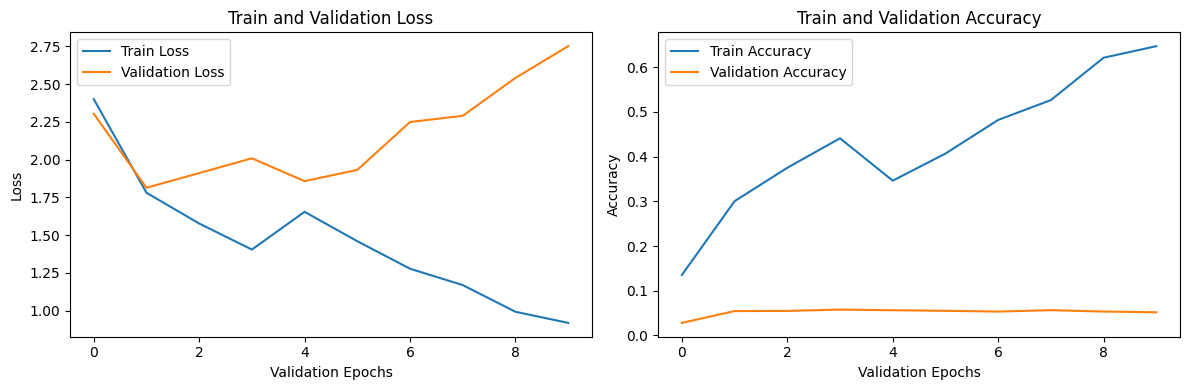

In [31]:
# Plot loss of training and validation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_xlabel('Validation Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train and Validation Loss')
axes[0].legend()

# Plot accuracies of training and validation
axes[1].plot(train_accuracies, label='Train Accuracy')
axes[1].plot(val_accuracies, label='Validation Accuracy')
axes[1].set_xlabel('Validation Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Train and Validation Accuracy')
axes[1].legend()
plt.tight_layout()
plt.show()

3200


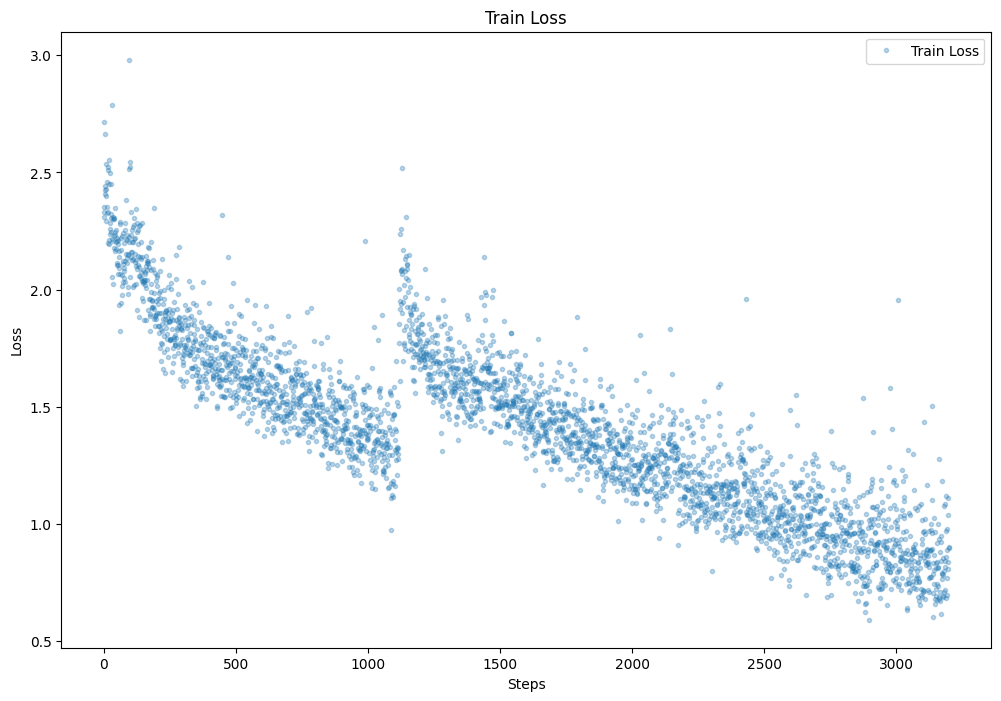

In [32]:
# all train losses
print(len(all_train_losses))
# plot all_train_losses
plt.figure(figsize=(12,8))
plt.plot(all_train_losses,  '.',label='Train Loss', alpha=0.3)
#plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.show()

In [33]:
# Load the best model from pth file type
device = torch.device("cpu")
flow_models = []
for class_label in range(num_classes):
    conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
    flows = [affine_coupling for _ in range(num_flows)]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device))

    flow_model = NormalisingFlow(latent_distribution, flows). to(device)
    #flow_model = NormalisingFlow(latent_distribution, flows).apply(init_weights).to(device)
    flow_models.append(flow_model)
best_model = PosteriorNetwork(latent_dim, flow_models, N, num_classes, y_train).to(device)
best_model.load_state_dict(torch.load('best_model_cifar10.pth', map_location=device)['model_state_dict'])
#best_model.eval()

<All keys matched successfully>

In [34]:
# Test best model on test data
N = N.to(device) #move num classes to device just in case
alpha_values = []
# print(next(best_model.parameters()).is_cuda)
best_model.eval()
with torch.no_grad():
    for batch_index, (X_test_batch, y_test_batch) in enumerate(test_loader):
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        # Forward pass to compute alpha values for this batch
        alpha_preds = best_model(X_test_batch, N) # batch x num_classes    
        # Append the alpha values to the list
        #print(alpha_preds.shape)
        alpha_values.append(alpha_preds)

# Combine alpha values from all batches list into a single tensor
alpha_values = torch.cat(alpha_values, dim=0)
print("Alpha values shape: ", alpha_values.shape)

# Normalize alpha values
alphas_norm = F.normalize(alpha_values, p=1, dim=1) #reduce to dim 1, sum to 1

Alpha values shape:  torch.Size([1984, 10])


In [37]:
# Explore feature space
def plot_latent_space(flow_model, num_samples, class_label):
    z = flow_model.latent_sample(num_samples)
    x = flow_model.g(z)
    x = x.detach().cpu().numpy()
    z = z.detach().cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.scatter(z[:, 0], z[:, 1], c=class_label, cmap='tab10', alpha=0.5)
    plt.title('Latent space')
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.scatter(x[:, 0], x[:, 1], c=class_label, cmap='tab10', alpha=0.5)
    plt.title('Feature space')
    plt.show()

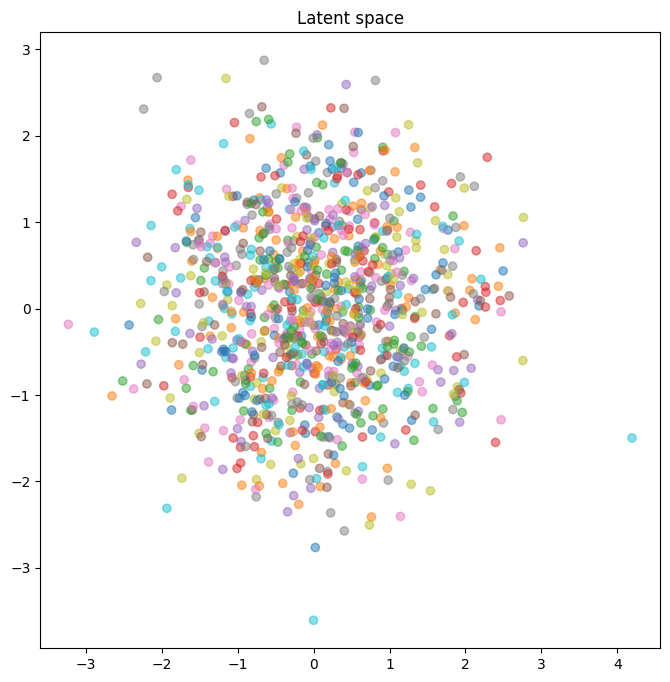

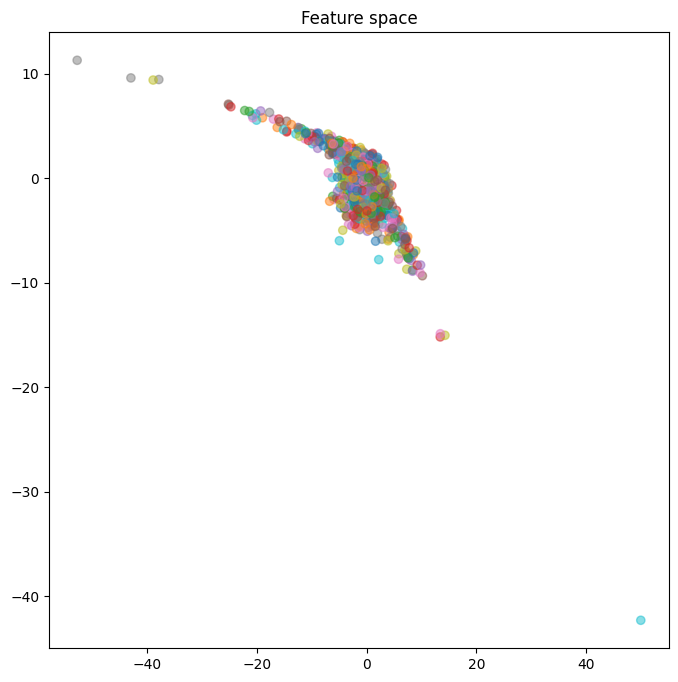

In [41]:
# Plot the latent space for class 0

plt.scatter(X_train[y_train == 0][:, 0])

plot_latent_space(flow_models[0], 